### Load Data

In [2]:
import pandas as pd

data = pd.read_csv("test_predictions.csv")
data.columns

Index(['FailingMethod', 'Prediction', 'Answer.explanation'], dtype='object')

### Concatenate explanations for each bug report

In [3]:
test_bug_reports = [0, 1]
filtered_data = data[
    (data["FailingMethod"].isin(test_bug_reports)) & (data["Prediction"] == 1)
]

grouped_explanations = (
    filtered_data.groupby("FailingMethod")["Answer.explanation"].apply(list).to_dict()
)

grouped_explanations.values()

dict_values([["This shouldn't be causing an out of range error because this is only looking to see if the inputs are 0 so that shouldn't be the issue here.", 'The logic check for an offset of 0 hours and 0 minutes works correctly and is unrelated to this exception.', 'the conditional clause throws an error if the value of minutes is smaller than zero', 'According to the comments; the minute value should be between -59 and +59; but the conditional statement is checking for a value between 0 and 59.', 'the code is incomplete. it properly checks for greater than 59 but neglects to take into account if the hours are negative before rejecting minutes for being negative. it would be more correct though not completely to check for less than -59 instead of less than 0', 'It will return the offset', 'Line 279 written as "minutesOffset < 0" makes it clear it\'s the one throwing the Exception; as the -15 in the minutes spot is clearly less than 0.', 'This conditional will reject any negative minu

### Summarize with Bart

In [4]:
from transformers import pipeline

summarizer = pipeline("summarization")

consolidated_explanations = {}
for bug_id, explanations in grouped_explanations.items():
    combined_text = " ".join(explanations)

    max_input_length = 1024
    combined_text = combined_text[:max_input_length]

    summary = summarizer(
        combined_text, max_length=100, min_length=30, do_sample=False, truncation=True
    )
    consolidated_explanations[bug_id] = summary[0]["summary_text"]

for bug_id, explanation in consolidated_explanations.items():
    print(f"Bug Report {bug_id}:\n{explanation}\n")

/home/elena.gensch/miniconda3/envs/mp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Bug Report 0:
 The logic check for an offset of 0 hours and 0 minutes works correctly and is unrelated to this exception . The conditional clause throws an error if the value of minutes is smaller than zero .

Bug Report 1:
 "g" might exceed -255 or 255 which is not a valid value for the Color object . The variable is being defined correctly as a parameter of the getPaint method . Nothing in this method checks that the lower range of value is positive -- therefore a negative number is not sanitized .



### Summarizing with LLAMA

In [5]:
import os
from typing import Dict, List
from huggingface_hub import login
from openai import OpenAI
from transformers import AutoTokenizer, PreTrainedTokenizerFast
from omegaconf import DictConfig

MODEL_NAME = "neuralmagic/Meta-Llama-3.1-405B-Instruct-quantized.w4a16"
ANSWER_TOKEN_LENGTH = 2048
MODEL_TEMPERATURE = 0.2


class Assistant:
    model_name: str
    temperature: float
    _client: OpenAI
    _system_message: Dict[str, str]
    _messages: List[Dict[str, str]]
    _tokenizer: PreTrainedTokenizerFast

    def __init__(self, model_name: str, model_temperature: float):
        login(token=SECRET_TOKEN)
        self._client = OpenAI(base_url=os.getenv("VLLM_BASE_URL"))
        self._system_message = {
            "role": "system",
            "content": (
                "You are an AI assistant helping to summarize explanations for software bugs. "
                "Provide concise, clear explanations based on input."
            ),
        }
        self._messages = []
        self.temperature = model_temperature
        self.model_name = model_name
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        assert (
            self._tokenizer != False
        ), f"Something went wrong when fetching the default tokenizer for model {model_name}"

    def _all_messages(self):
        return [self._system_message] + self._messages

    def _tokenized_messages(self):
        return self._tokenizer.apply_chat_template(self._all_messages(), tokenize=True)

    def generate_answer(self, prompt: str) -> str:
        self._messages += [
            {"role": "user", "content": prompt},
        ]
        num_tokens = len(self._tokenized_messages())
        while num_tokens > ANSWER_TOKEN_LENGTH:
            self._messages.pop(0)
            num_tokens = len(self._tokenized_messages())

        completion = self._client.completions.create(
            model=self.model_name,
            max_tokens=ANSWER_TOKEN_LENGTH,
            prompt=self._tokenized_messages(),
            temperature=self.temperature,
        )
        answer = completion.choices.pop().text
        self._messages += [
            {
                "role": "assistant",
                "content": answer,
            }
        ]

        return answer

In [6]:
import pandas as pd


def summarize_explanations_with_assistant(
    grouped_explanations, assistant: Assistant, prompt_template: str
):
    """
    Summarizes explanations using the Assistant class.

    Args:
        grouped_explanations (dict): Grouped explanations by bug ID.
        assistant (Assistant): An instance of the Assistant class.
        prompt_template (str): Prompt template with a placeholder for explanations.

    Returns:
        dict: Summarized explanations for each bug ID.
    """
    summarized_answers = {}
    for bug_id, explanations in grouped_explanations.items():
        combined_text = "\n".join(explanations)

        prompt = prompt_template.format(combined_text=combined_text)

        summary = assistant.generate_answer(prompt)
        summarized_answers[bug_id] = summary.strip()

    return summarized_answers

In [7]:
VANILLA_PROMPT = "Summarize this\n\n{combined_text}"
CHAT_PROMPT = (
    "You are a highly skilled AI assistant designed to analyze and consolidate explanations for software bugs. "
    "Your task is to generate a single explanation that minimizes redundancy while preserving the critical information "
    "necessary for a developer to fix the issue. Below are some explanations provided by different participants regarding the same bug.\n\n"
    "Explanations:\n{combined_text}\n\n"
    "Requirements for the single summarizing Explanation:\n"
    "1. Describe how the program works in the context of the bug.\n"
    "2. Explain how the failure occurs, including specific conditions or steps leading to the issue.\n"
    "3. Identify and describe the root cause of the problem in the code.\n"
    "4. Make the explanation concise and free of unnecessary repetition. Ensure clarity for a developer reading it.\n\n"
)


CHAT_COT_PROMPT = (
    "You are a highly skilled AI assistant designed to analyze and consolidate explanations for software bugs. "
    "Your task is to generate a single explanation that minimizes redundancy while preserving the critical information "
    "necessary for a developer to fix the issue. Below are some explanations provided by different participants regarding the same bug.\n\n"
    "Explanations:\n{combined_text}\n\n"
    "Requirements for the Explanation:\n"
    "1. Describe how the program works in the context of the bug.\n"
    "2. Explain how the failure occurs, including specific conditions or steps leading to the issue.\n"
    "3. Identify and describe the root cause of the problem in the code.\n"
    "4. Make the explanation concise and free of unnecessary repetition. Ensure clarity for a developer reading it.\n\n"
    "Step-by-step reasoning to consolidate the explanation:\n"
    "1. Analyze each explanation to identify overlapping information and unique insights.\n"
    "2. Determine the most relevant points about how the program works, why it fails, and what the root cause is.\n"
    "3. Synthesize these points into a cohesive explanation that is concise yet comprehensive.\n\n"
    "Final Explanation:"
)

In [8]:
assistant = Assistant(model_name=MODEL_NAME, model_temperature=MODEL_TEMPERATURE)

summarized_answers_vanilla = summarize_explanations_with_assistant(
    grouped_explanations, assistant, VANILLA_PROMPT
)
summarized_answers_chat = summarize_explanations_with_assistant(
    grouped_explanations, assistant, CHAT_PROMPT
)

summarized_answers_chat_cot = summarize_explanations_with_assistant(
    grouped_explanations, assistant, CHAT_COT_PROMPT
)

In [9]:
for bug_id, summary in summarized_answers_chat_cot.items():
    print(f"Bug Report {bug_id}:\n{summary}\n")

Bug Report 0:
Here is the consolidated explanation:

The program uses the `DateTimeZone.forOffsetHoursMinutes` method to create a time zone instance with a specified offset from UTC. The method takes two parameters, `hoursOffset` and `minutesOffset`, which are expected to be within the range of -59 to 59 minutes.

The failure occurs when the `minutesOffset` value is negative, specifically when it is -15 in this case. The code checks if `minutesOffset` is less than 0 or greater than 59 in line 279, and since -15 is less than 0, it throws an `IllegalArgumentException` on line 280.

The root cause of the problem is that the code does not correctly handle negative `minutesOffset` values when the `hoursOffset` is also negative. According to the comments, the method should allow negative minutes if the hours are negative, but the code rejects all negative minutes with an exception. To fix the issue, the code should be modified to correctly handle negative `minutesOffset` values based on the 

In [10]:
for bug_id, summary in summarized_answers_chat.items():
    print(f"Bug Report {bug_id}:\n{summary}\n")

Bug Report 0:
Here is a single summarizing explanation that meets the requirements:

The program attempts to create a `DateTimeZone` instance using the `forOffsetHoursMinutes` method, which takes two parameters: `hoursOffset` and `minutesOffset`. The method checks if the `minutesOffset` value is within the range of 0 to 59. However, the code throws an `IllegalArgumentException` when the `minutesOffset` value is negative, regardless of the `hoursOffset` value.

The failure occurs when the `forOffsetHoursMinutes` method is called with a negative `minutesOffset` value, such as -15. The method checks the value of `minutesOffset` on line 279 and throws an exception when it finds that the value is less than 0.

The root cause of the problem is that the code does not correctly handle negative `minutesOffset` values when the `hoursOffset` value is also negative. According to the comments, the method should allow negative `minutesOffset` values when the `hoursOffset` value is negative, but the 

### Try LLAMA and DSPY COT

In [11]:
import requests
from huggingface_hub import login, HfApi
import os
import dspy

MODEL_NAME = "openai/neuralmagic/Meta-Llama-3.1-405B-Instruct-quantized.w4a16"
ANSWER_TOKEN_LENGTH = 2048
MODEL_TEMPERATURE = 0.2


# Login to Hugging Face using the API Key
# login(token=api_key)
model = dspy.LM(
    model=MODEL_NAME,
    api_key=os.getenv("OPENAI_API_KEY"),
    api_base=os.getenv("VLLM_BASE_URL"),
    model_type="chat",
    cache=False,
)

dspy.settings.configure(lm=model)


# TEST
class BasicQA(dspy.Signature):
    """Answer questions with short factoid answers."""

    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")


generate_answer = dspy.Predict(BasicQA)

question = "What is the color of the sky?"
pred = generate_answer(question=question)
pred

Prediction(
    answer='Blue'
)

In [12]:
import dspy

sig = dspy.Signature("text -> summary")

In [13]:
chain_of_thought = dspy.ChainOfThought(
    steps=[
        "Step 1: Analyze the provided explanations and identify key points or themes.",
        "Step 2: Highlight the root cause of the bug and describe it clearly.",
        "Step 3: Combine overlapping explanations and remove redundancy.",
        "Step 4: Provide a single concise explanation for the bug that includes all critical information.",
    ],
    lm=model,
    max_tokens_per_step=500,
    temperature=MODEL_TEMPERATURE,
    signature=sig,
)

In [14]:
class BasicSummarization(dspy.Signature):
    code_explanations = dspy.InputField(
        desc="concatenated explanations for code errors made by programmers"
    )
    summary = dspy.OutputField(desc="often between 4 and 7 sentences")


generate_answer = dspy.ChainOfThought(BasicSummarization)

In [15]:
def summarize_code_explanations_with_cot(grouped_explanations, cot, prompt_template):
    """
    Summarizes grouped code explanations using the Chain of Thought reasoning.

    Args:
        grouped_explanations (dict): Dictionary of bug IDs and corresponding explanations.
        cot (dspy.ChainOfThought): Initialized Chain of Thought object.
        prompt_template (str): Prompt template with placeholders for explanations.

    Returns:
        dict: Summarized explanations for each bug ID.
    """
    summarized_explanations = {}

    for bug_id, explanations in grouped_explanations.items():
        # Combine explanations into a single text block
        combined_text = "\n".join(explanations)
        # prompt = prompt_template.format(combined_text)
        # Execute the Chain of Thought reasoning
        result = cot(code_explanations=combined_text)

        # Store the summarized explanation
        summarized_explanations[bug_id] = result["summary"].strip()

    return summarized_explanations

In [16]:
summarized_answers_dspy = summarize_code_explanations_with_cot(
    grouped_explanations, generate_answer, CHAT_PROMPT
)

In [17]:
summarized_answers_dspy

{0: 'The code is throwing an exception because it is rejecting all negative minute values, even when the hour value is also negative. The comments in the code suggest that this is not the intended behavior, and that negative minute values should be allowed when the hour value is negative. The issue is with the conditional statement on line 279, which should be modified to allow negative minute values when the hour value is also negative. The correct behavior would be to check if the minute value is less than -59, rather than less than 0. This would ensure that the code correctly handles negative minute values and does not throw an exception unnecessarily.',
 1: 'The issue is with the variable "g" exceeding the valid range for the Color object. The calculation of "g" can result in a negative integer value if the parameter "value" is negative, and there is no check to prevent this. The Color constructor is being called with three float parameters, but the value of "g" is being cast to an

### Summarization with ChatGPT 

we pasted them directly into the dictionaries below

In [18]:
summarization_chat_gpt_generated_prompt = {
    0: "The issue occurs when the DateTimeZone.forOffsetHoursMinutes method is called with a negative minutesOffset value, which is not properly handled by the code. Specifically, the code on line 279 checks for minutesOffset < 0 or minutesOffset > 59, and throws an IllegalArgumentException when the minute value is negative. The documentation suggests that negative minute values should be allowed if the hour offset is negative. To fix this, the condition should be updated to allow negative minute values in cases where the hour offset is also negative (i.e., check for minutesOffset < -59 instead of < 0). Additionally, the handling of the forOffsetHoursMinutes method and comments indicating expected behavior should be aligned to avoid this issue.",
    1: "The issue occurs when the g value passed to the Color constructor is out of the expected range (0 to 255). The calculation of g can produce a negative value if the input parameters result in that outcome, which the Color constructor does not accept. The root cause is that there is no validation or sanitation of the g value to ensure it falls within the valid range. To fix this, the value of g should be constrained to be between 0 and 255 before being passed to the Color constructor. Additionally, the behavior of the lower and upper bounds should be carefully examined to ensure they are properly defined and used.",
}

In [19]:
summarization_chat_gpt = {
    0: "The issue is caused by the `minutesOffset` being less than zero in the `DateTimeZone.forOffsetHoursMinutes()` method, which throws an `IllegalArgumentException` when the condition checks for negative minute values. The problem lies in the code's handling of negative minutes; while the logic allows for negative hours, it incorrectly rejects negative minutes. The correct solution would involve adjusting the conditional checks to accept negative values within a specific range, allowing consistency with the intended behavior described in the comments.",
    1: "The problem stems from the value of the variable `g` being outside the acceptable range for the `Color` class constructor. The calculation for `g` might result in a negative number, which causes an `IllegalArgumentException`. There is no check to ensure that `g` falls within the valid range (0 to 255) for color components. Adjusting the bounds and adding validation would prevent this error and ensure proper functionality with the `Color` constructor.",
}

In [20]:
summarized_chat_gpt_cot = {
    0: "The error occurs when calling DateTimeZone.forOffsetHoursMinutes(-2, -15) due to a conditional check in line 279 that rejects negative minute values. The function expects minute offsets between 0 and 59, and when -15 is provided, it throws an IllegalArgumentException. The root cause is the conditional clause in line 279 that does not allow negative minute values, even when the hour offset is negative. To resolve this, the check should be updated to allow negative minute offsets if the hour offset is also negative, ensuring consistency with the documentation that allows negative minutes when the hour offset is negative.",
    1: "The issue arises when passing the value of g to the Color constructor. The value of g is calculated using a formula that may result in a negative value if the input parameters (such as lowerBound and upperBound) are not properly validated. The Color constructor only accepts values for RGB components within the range of 0 to 255. If g is negative, it will throw an IllegalArgumentException. To fix this, ensure that the calculated value for g is always within the acceptable range before passing it to the Color constructor.",
}

### Compare summarized explanations

In [21]:
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk

nltk.download("punkt_tab")


def ttr(text: str) -> float:
    """
    Calculate the Type-Token Ratio (TTR), a measure of lexical diversity.
    """
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens)


def analyze_explanation(explanation):
    """
    Analyze the size and complexity of explanations.
    """

    # Size Metrics
    word_count = len(word_tokenize(explanation))
    unique_word_count = len(set(word_tokenize(explanation)))

    # Complexity Metrics
    lexical_diversity = ttr(explanation)
    sentences = sent_tokenize(explanation)
    avg_sentence_length = word_count / len(sentences) if sentences else 0

    return {
        "word_count": word_count,
        "ttr": ttr(explanation),
        "unique_word_count": unique_word_count,
        "lexical_diversity": lexical_diversity,
        "avg_sentence_length": avg_sentence_length,
    }

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/elena.gensch/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
for bug_id, explanations in grouped_explanations.items():
    print(bug_id, analyze_explanation(summarized_answers_dspy[bug_id]))
    print(bug_id, analyze_explanation(summarized_answers_chat[bug_id]))
    print(bug_id, analyze_explanation(summarized_answers_chat_cot[bug_id]))
    print(bug_id, analyze_explanation(summarized_answers_dspy[bug_id]))
    print(bug_id, analyze_explanation(summarized_answers_vanilla[bug_id]))
    print(bug_id, analyze_explanation(summarization_chat_gpt[bug_id]))
    print(bug_id, analyze_explanation(summarization_chat_gpt_generated_prompt[bug_id]))
    print(bug_id, analyze_explanation(summarization_chat_gpt_generated_prompt[bug_id]))

0 {'word_count': 122, 'ttr': 0.4918032786885246, 'unique_word_count': 60, 'lexical_diversity': 0.4918032786885246, 'avg_sentence_length': 24.4}
0 {'word_count': 248, 'ttr': 0.3467741935483871, 'unique_word_count': 86, 'lexical_diversity': 0.3467741935483871, 'avg_sentence_length': 27.555555555555557}
0 {'word_count': 236, 'ttr': 0.4533898305084746, 'unique_word_count': 107, 'lexical_diversity': 0.4533898305084746, 'avg_sentence_length': 29.5}
0 {'word_count': 122, 'ttr': 0.4918032786885246, 'unique_word_count': 60, 'lexical_diversity': 0.4918032786885246, 'avg_sentence_length': 24.4}
0 {'word_count': 112, 'ttr': 0.5267857142857143, 'unique_word_count': 59, 'lexical_diversity': 0.5267857142857143, 'avg_sentence_length': 28.0}
0 {'word_count': 92, 'ttr': 0.6956521739130435, 'unique_word_count': 64, 'lexical_diversity': 0.6956521739130435, 'avg_sentence_length': 30.666666666666668}
0 {'word_count': 127, 'ttr': 0.5905511811023622, 'unique_word_count': 75, 'lexical_diversity': 0.59055118110

hiii    count  bug_id   model  word_count       ttr        ID
0      0       0   llama         112  0.526786  HIT02_24
1      0       0  gpt-4o          92  0.695652  HIT02_24
2      0       1   llama         122  0.508197  HIT06_51
3      0       1  gpt-4o          90  0.655556  HIT06_51


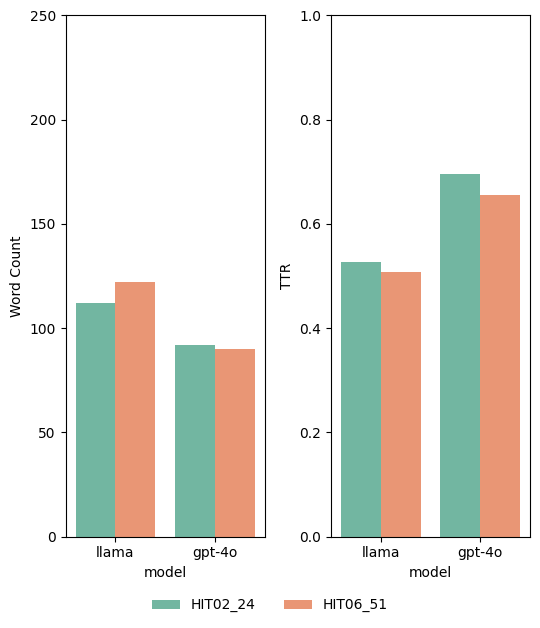

hiii    count  bug_id   model  word_count       ttr        ID
4      1       0   llama         248  0.346774  HIT02_24
5      1       0  gpt-4o         127  0.590551  HIT02_24
6      1       1   llama         221  0.411765  HIT06_51
7      1       1  gpt-4o         122  0.590164  HIT06_51


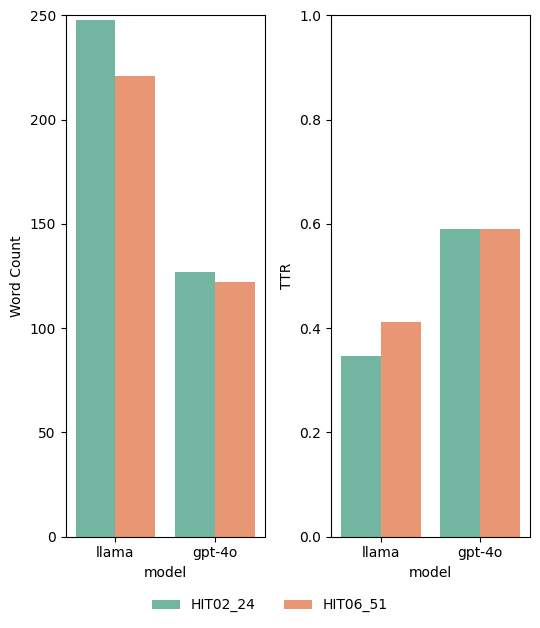

hiii     count  bug_id   model  word_count       ttr        ID
8       2       0   llama         236  0.453390  HIT02_24
9       2       0  gpt-4o         110  0.563636  HIT02_24
10      2       1   llama         300  0.360000  HIT06_51
11      2       1  gpt-4o          99  0.616162  HIT06_51


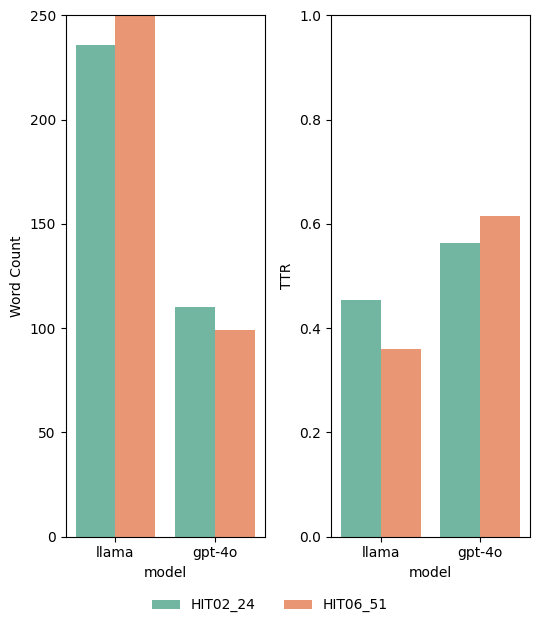

hiii     count  bug_id  model  word_count       ttr        ID
12      3       0  llama         122  0.491803  HIT02_24
13      3       1  llama         136  0.477941  HIT06_51


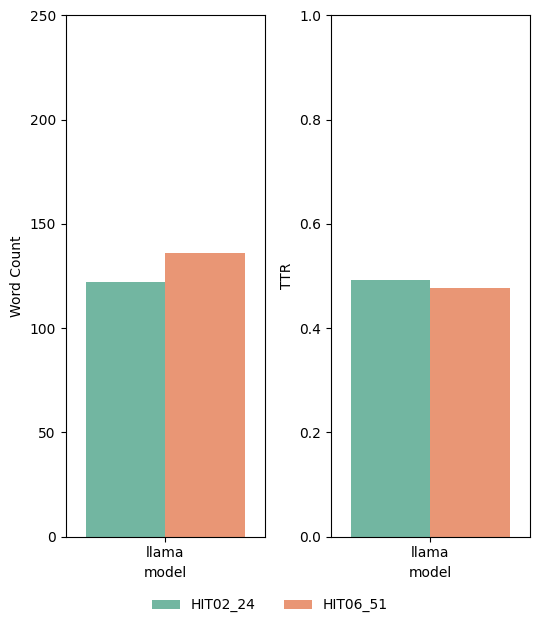

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

# For demonstration, the bug IDs you want to process
bug_ids = [0, 1]

# Prepare the data for plotting
plot_data = []


# Function to gather data for a specific chart using the existing dictionaries
def gather_data_for_chart(bug_ids, model_data_map, model_name_map, count):
    for bug_id in bug_ids:
        for model_name, model_data in model_data_map.items():
            # Directly access the data using the bug_id from the model_data dictionary
            explanation = analyze_explanation(
                model_data[bug_id]
            )  # Access explanation directly from the model data
            plot_data.append(
                {
                    "count": count,
                    "bug_id": bug_id,
                    "model": model_name_map.get(model_name, model_name),
                    "word_count": explanation.get(
                        "word_count", 0
                    ),  # Safely access 'word_count'
                    "ttr": explanation.get("ttr", 0),  # Safely access 'ttr'
                }
            )


# Define the model data (using the actual model dictionaries like summarized_answers_vanilla, etc.)
model_data_map_1 = {
    "llama": summarized_answers_vanilla,
    "gpt-4o": summarization_chat_gpt,
}

model_name_map_1 = {"llama": "llama", "gpt-4o": "gpt-4o"}

model_data_map_2 = {
    "llama": summarized_answers_chat,
    "gpt-4o": summarization_chat_gpt_generated_prompt,
}

model_name_map_2 = {"llama": "llama", "gpt-4o": "gpt-4o"}

model_data_map_3 = {
    "llama": summarized_answers_chat_cot,
    "gpt-4o": summarized_chat_gpt_cot,
}

model_name_map_3 = {"llama": "llama", "gpt-4o": "gpt-4o"}

model_data_map_4 = {"llama": summarized_answers_dspy}

model_name_map_4 = {"llama": "llama"}

# Gather data for each chart
gather_data_for_chart(bug_ids, model_data_map_1, model_name_map_1, 0)
gather_data_for_chart(bug_ids, model_data_map_2, model_name_map_2, 1)
gather_data_for_chart(bug_ids, model_data_map_3, model_name_map_3, 2)
gather_data_for_chart(bug_ids, model_data_map_4, model_name_map_4, 3)

# Convert the collected data into a pandas DataFrame
df = pd.DataFrame(plot_data)

bug_id_label_map = {0: "HIT02_24", 1: "HIT06_51"}

# Apply the mapping to the DataFrame
df["ID"] = df["bug_id"].map(bug_id_label_map)

# Set up the color palette
palette = {"llama": "blue", "gpt-4o": "red"}


# Function to plot the charts with two subplots (word_count and ttr)
def plot_chart_combined(data, model_data_map_name):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, ax = plt.subplots(1, 2, figsize=(5.5, 6))
    print("hiii", data)
    # Plot Word Count on the first subplot
    sns.barplot(
        data=data,
        x="model",
        y="word_count",
        hue="ID",
        palette="Set2",
        ax=ax[0],
        edgecolor=None,  # Remove the black border
    )
    ax[0].set_ylabel("Word Count")
    ax[0].grid(False)  # Disable grid

    # Plot TTR on the second subplot
    sns.barplot(
        data=data,
        x="model",
        y="ttr",
        hue="ID",
        palette="Set2",
        ax=ax[1],
        edgecolor=None,  # Remove the black border
    )
    ax[1].set_ylabel("TTR")
    ax[0].set_ylim(0, 250)  # Set y-axis range for Word Count
    ax[1].set_ylim(0, 1)  # Set y-axis range for Word Count

    ax[1].grid(False)  # Disable grid

    ax[0].legend_.remove()
    ax[1].legend_.remove()

    # Add a shared legend at the bottom of the figure
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=2,  # Number of columns for the legend
        frameon=False,  # Remove legend box frame
    )

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the combined figure with both plots
    plt.show()


# Plot for each bug_id individually (word_count and ttr) for each model data map
# for bug_id in bug_ids:
# Filter data for the current bug_id


# Plot for each model data map (model_data_map_1 to model_data_map_4)
plot_chart_combined(df[df["count"].isin([0])], "model_data_map_1")
plot_chart_combined(df[df["count"].isin([1])], "model_data_map_2")
plot_chart_combined(df[df["count"].isin([2])], "model_data_map_3")
plot_chart_combined(df[df["count"].isin([3])], "model_data_map_4")

In [24]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.cider.cider import Cider


def compute_metrics(reference, summary):
    """
    Compute ROUGE, BLEU, SPICE, and CIDEr scores for a given reference and summary.
    """
    metrics = {}

    # Compute ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = scorer.score(reference, summary)
    metrics["rouge1"] = rouge_scores["rouge1"].fmeasure
    metrics["rouge2"] = rouge_scores["rouge2"].fmeasure
    metrics["rougeL"] = rouge_scores["rougeL"].fmeasure

    # Compute BLEU
    smoothing_function = SmoothingFunction().method1
    metrics["bleu"] = sentence_bleu(
        [reference.split()], summary.split(), smoothing_function=smoothing_function
    )

    # Compute SPICE
    spice_evaluator = Spice()
    spice_scores = spice_evaluator.compute_score({0: [reference]}, {0: [summary]})
    metrics["spice"] = spice_scores[0]

    # Compute CIDEr
    cider_evaluator = Cider()
    cider_scores = cider_evaluator.compute_score({0: [reference]}, {0: [summary]})
    metrics["cider"] = cider_scores[0]

    return metrics


# Evaluate Summaries Against Original Explanations
all_metrics = {}
for bug_id, explanations in grouped_explanations.items():
    # Prepare reference text (concatenated original explanations)
    reference_text = " ".join(explanations)

    # Evaluate each summarized explanation
    summaries = {
        "llama_dspy": summarized_answers_dspy[bug_id],
        "llama": summarized_answers_vanilla[bug_id],
        "llama_gp": summarized_answers_chat[bug_id],
        "llama_cot": summarized_answers_chat_cot[bug_id],
        "chat_gpt": summarization_chat_gpt[bug_id],
        "chat_gpt_gp": summarization_chat_gpt_generated_prompt[bug_id],
        "chat_gpt_cot": summarized_chat_gpt_cot[bug_id],
    }

    all_metrics[bug_id] = {}
    for model_name, summary in summaries.items():
        all_metrics[bug_id][model_name] = compute_metrics(reference_text, summary)

# Print Results
for bug_id, metrics in all_metrics.items():
    print(f"Bug ID: {bug_id}")
    for model_name, scores in metrics.items():
        print(f"  {model_name}:")
        for metric, value in scores.items():
            print(f"    {metric}: {value:.4f}")

Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 16.56 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 15.98 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 17.25 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 17.20 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 17.59 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 16.36 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 16.51 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4 sec].
Loading classif

SPICE evaluation took: 6.742 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4 sec].
Loading classif

SPICE evaluation took: 6.759 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 7.370 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 8.355 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 5.941 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4 sec].
Loading classif

SPICE evaluation took: 6.872 s


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3 sec].
Loading classif

SPICE evaluation took: 6.427 s
Bug ID: 0
  llama_dspy:
    rouge1: 0.1862
    rouge2: 0.0987
    rougeL: 0.1164
    bleu: 0.0001
    spice: 0.0887
    cider: 0.0000
  llama:
    rouge1: 0.1603
    rouge2: 0.1095
    rougeL: 0.1038
    bleu: 0.0000
    spice: 0.1172
    cider: 0.0000
  llama_gp:
    rouge1: 0.2807
    rouge2: 0.1172
    rougeL: 0.1437
    bleu: 0.0023
    spice: 0.1606
    cider: 0.0000
  llama_cot:
    rouge1: 0.2848
    rouge2: 0.1368
    rougeL: 0.1615
    bleu: 0.0030
    spice: 0.1661
    cider: 0.0000
  chat_gpt:
    rouge1: 0.1275
    rouge2: 0.0611
    rougeL: 0.0795
    bleu: 0.0000
    spice: 0.1226
    cider: 0.0000
  chat_gpt_gp:
    rouge1: 0.1828
    rouge2: 0.0969
    rougeL: 0.1039
    bleu: 0.0000
    spice: 0.1293
    cider: 0.0000
  chat_gpt_cot:
    rouge1: 0.1614
    rouge2: 0.0799
    rougeL: 0.0997
    bleu: 0.0000
    spice: 0.1622
    cider: 0.0000
Bug ID: 1
  llama_dspy:
    rouge1: 0.4469
    rouge2: 0.2266
    rougeL: 0.2473
    bleu: 0.0288


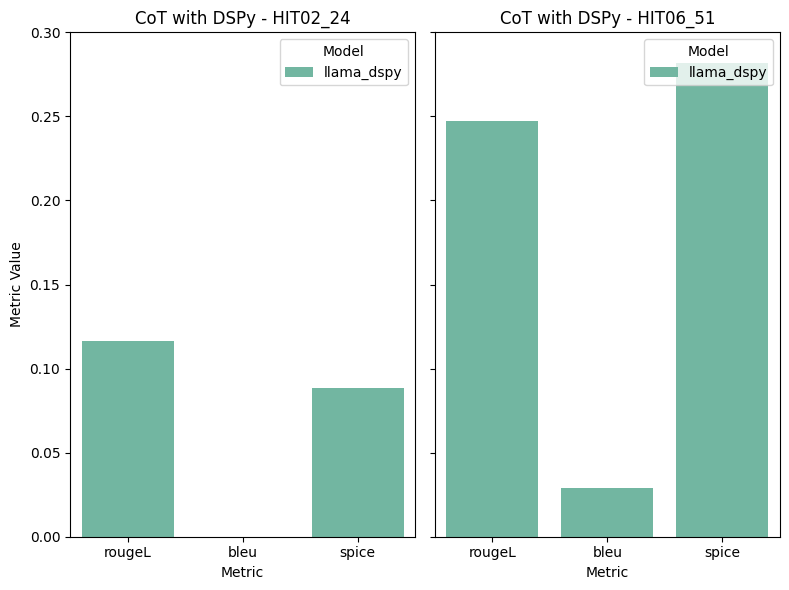

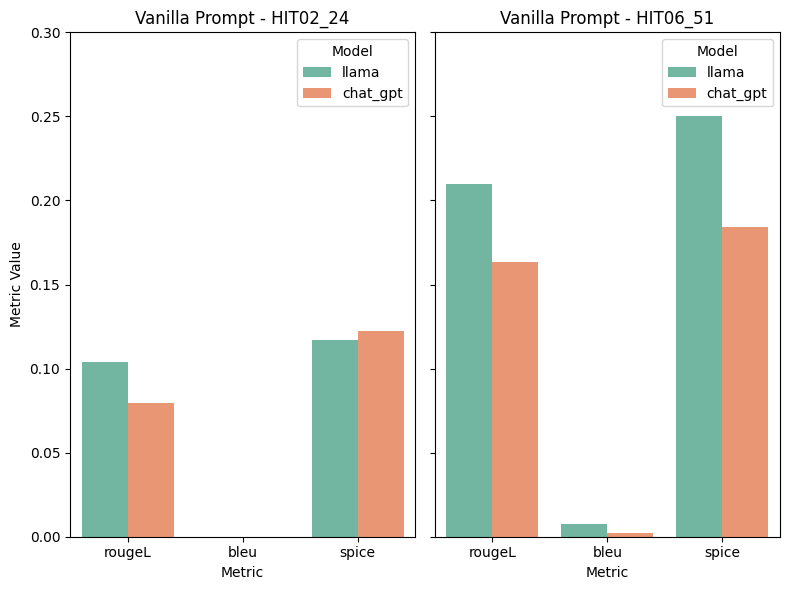

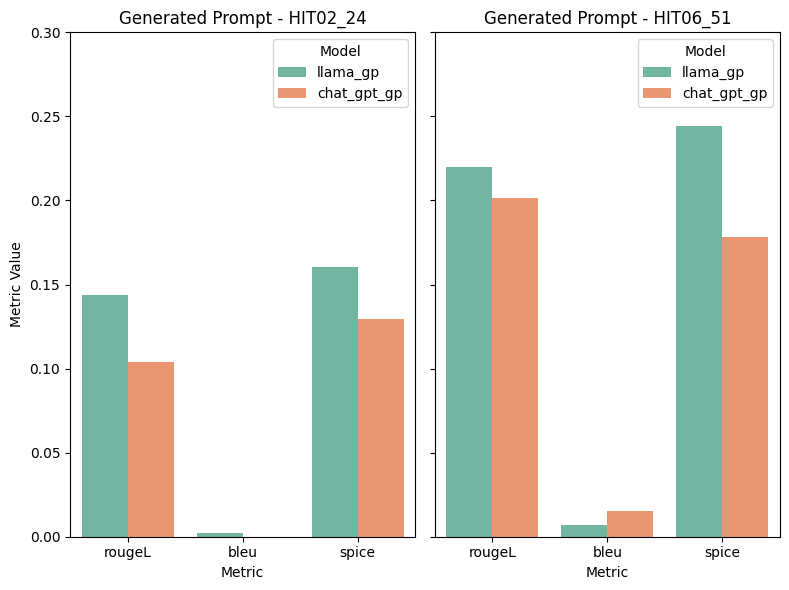

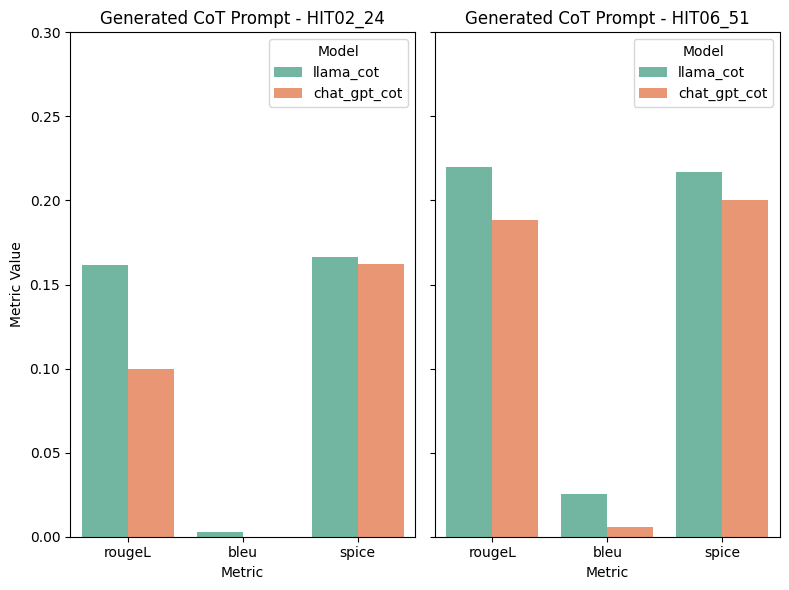

In [34]:
data = []
for bug_id, metrics in all_metrics.items():
    for model_name, scores in metrics.items():
        for metric, value in scores.items():
            if metric in ["rougeL", "bleu", "spice"]:  # Only include selected metrics

                data.append(
                    {
                        "bug_id": bug_id,
                        "model": model_name,
                        "metric": metric,
                        "value": value,
                    }
                )

df = pd.DataFrame(data)

# Map models to plot groups
plot_groups = {
    "CoT with DSPy": ["llama_dspy"],
    "Vanilla Prompt": ["llama", "chat_gpt"],
    "Generated Prompt": ["llama_gp", "chat_gpt_gp"],
    "Generated CoT Prompt": ["llama_cot", "chat_gpt_cot"],
}

# Create separate DataFrames for each group
grouped_data = {
    name: df[df["model"].isin(models)] for name, models in plot_groups.items()
}


# Create subplots for each bug_id
bug_id_map = {0: "HIT02_24", 1: "HIT06_51"}
df["bug_id_label"] = df["bug_id"].map(bug_id_map)


# Plot function with two subplots for each group
def plot_group_with_subplots(data, group_name):
    # Separate data by bug ID
    data_bug0 = data[data["bug_id"] == 0]
    data_bug1 = data[data["bug_id"] == 1]

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

    # Plot for bug ID 0 (HIT02_24)
    sns.barplot(
        data=data_bug0, x="metric", y="value", hue="model", palette="Set2", ax=ax[0]
    )
    ax[0].set_title(f"{group_name} - HIT02_24")
    ax[0].set_ylabel("Metric Value")
    ax[0].set_ylim(0, 0.30)

    ax[0].legend(loc="upper right")

    # Plot for bug ID 1 (HIT06_51)
    sns.barplot(
        data=data_bug1, x="metric", y="value", hue="model", palette="Set2", ax=ax[1]
    )
    ax[1].set_title(f"{group_name} - HIT06_51")
    ax[1].set_ylabel("Metric Value")
    ax[1].legend(loc="upper right")
    ax[1].set_ylim(0, 0.30)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Iterate through grouped data and plot
for group_name, group_data in grouped_data.items():
    plot_group_with_subplots(group_data, group_name)